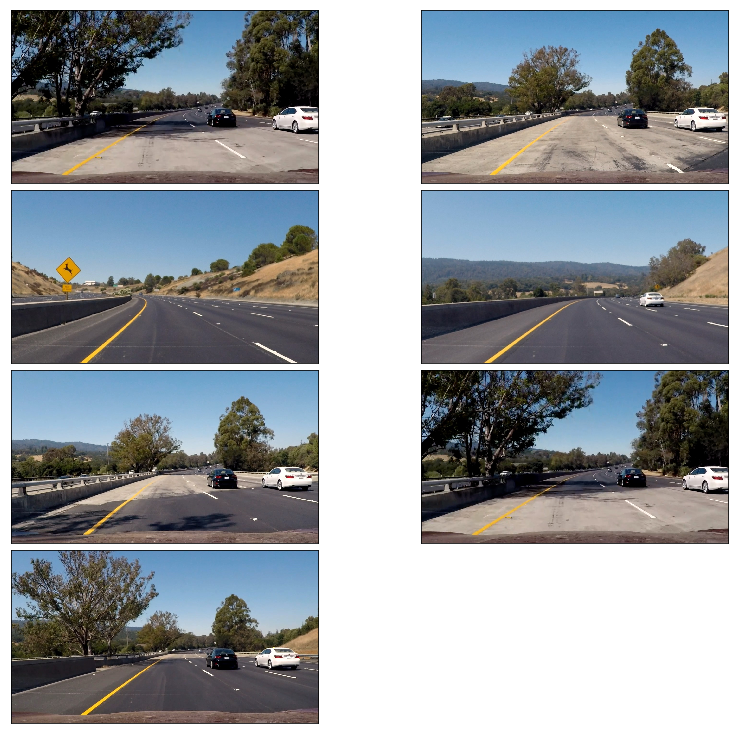

In [1]:
import numpy as np
import cv2, os, glob
import scipy
from scipy import signal
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from moviepy.editor import VideoFileClip
from CameraCalibrator import CameraCalibrator, display_undistorted_image, display_images_with_corners
from VisionFilters import VisionFilters
from Line import Line
from FindLines import FindLines

# Camera calibration constants
CAMERA_CAL_PICKLE = "camera_cal/calibration_data.p"
CAMERA_CAL_IMAGES = glob.glob('camera_cal/calibration*.jpg')
TEST_CAL_IMAGE_PATH = 'camera_cal\\calibration1.jpg'
CAMERA_CAL_IMAGES.remove(TEST_CAL_IMAGE_PATH)

# Test image constants
TEST_IMAGES_PATH = glob.glob('test_images/*.jpg')
TEST_FILE_NAME = 'test_images/test3.jpg'
OUTPUT_PATH = 'output_images/'

#reading in an image
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    plt.figure(figsize=(12, 10))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.imsave(OUTPUT_PATH + str(i), image)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

#printing out some stats and plotting
test_images = [plt.imread(path) for path in TEST_IMAGES_PATH]
show_images(test_images)

Recalibrating the camera...


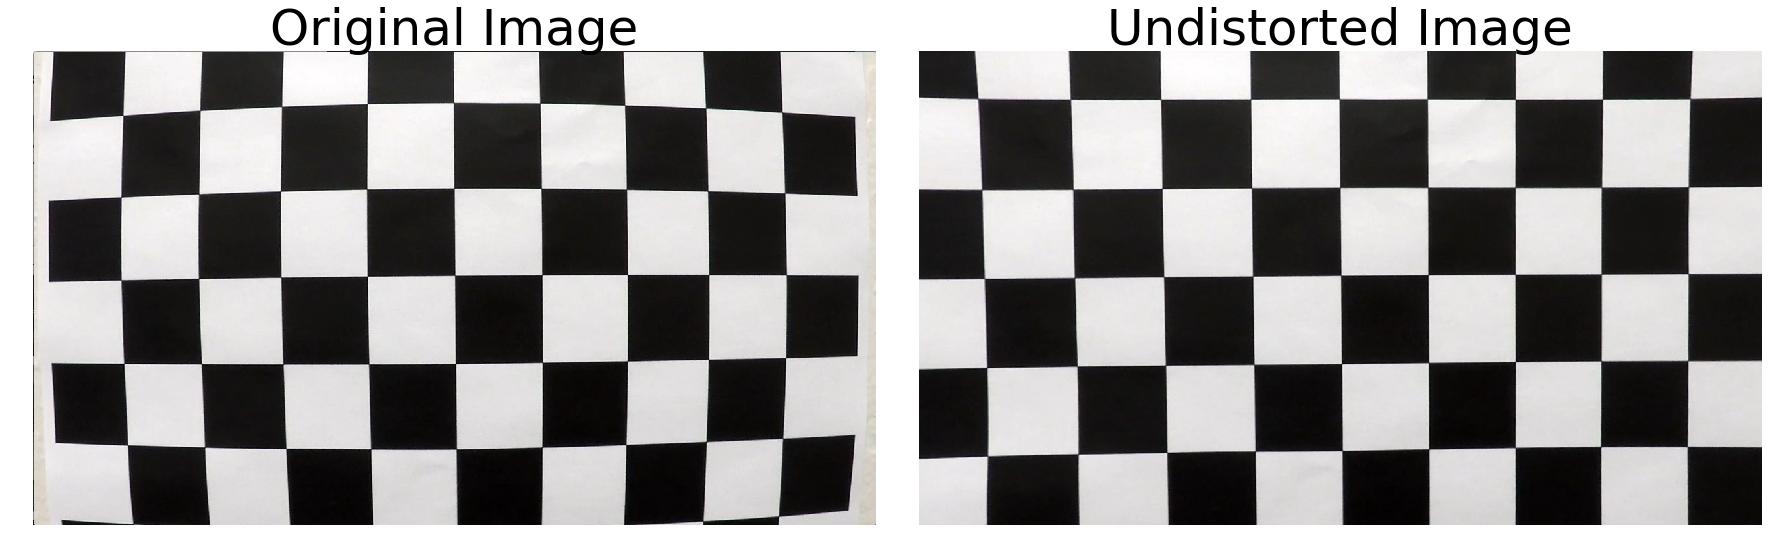

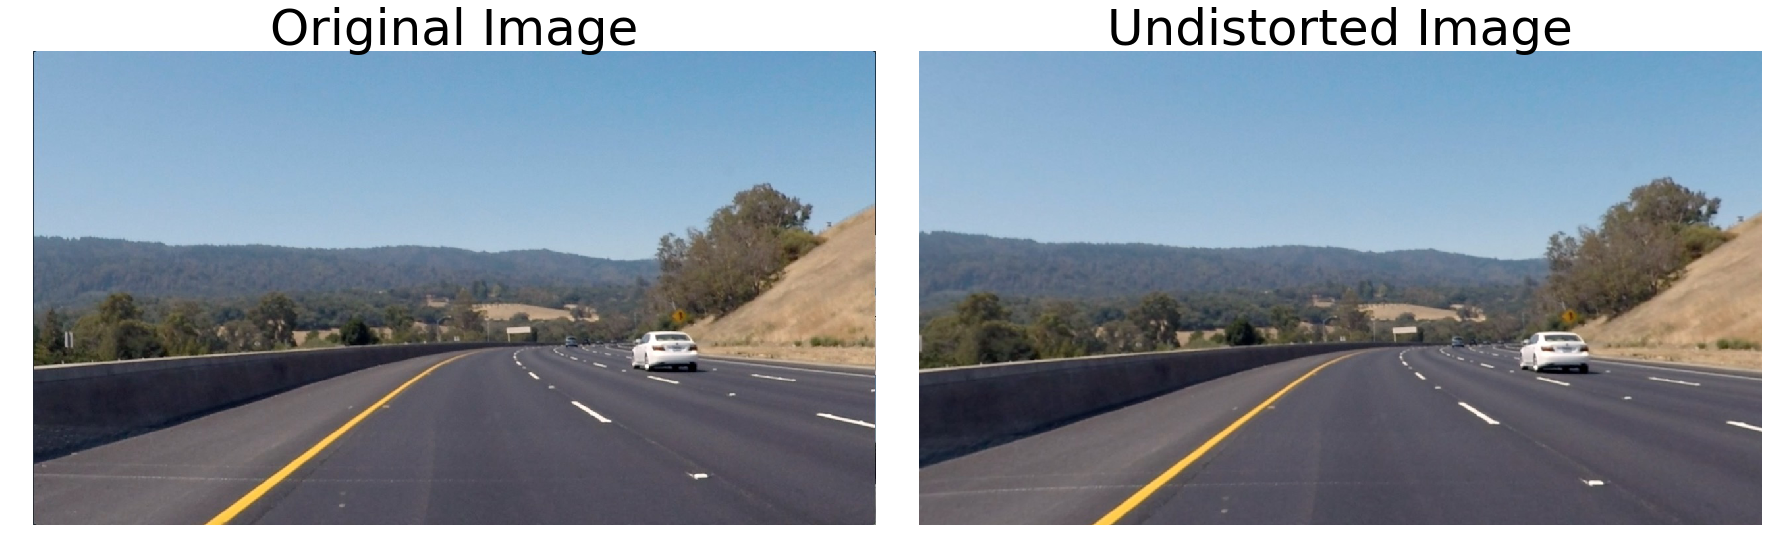

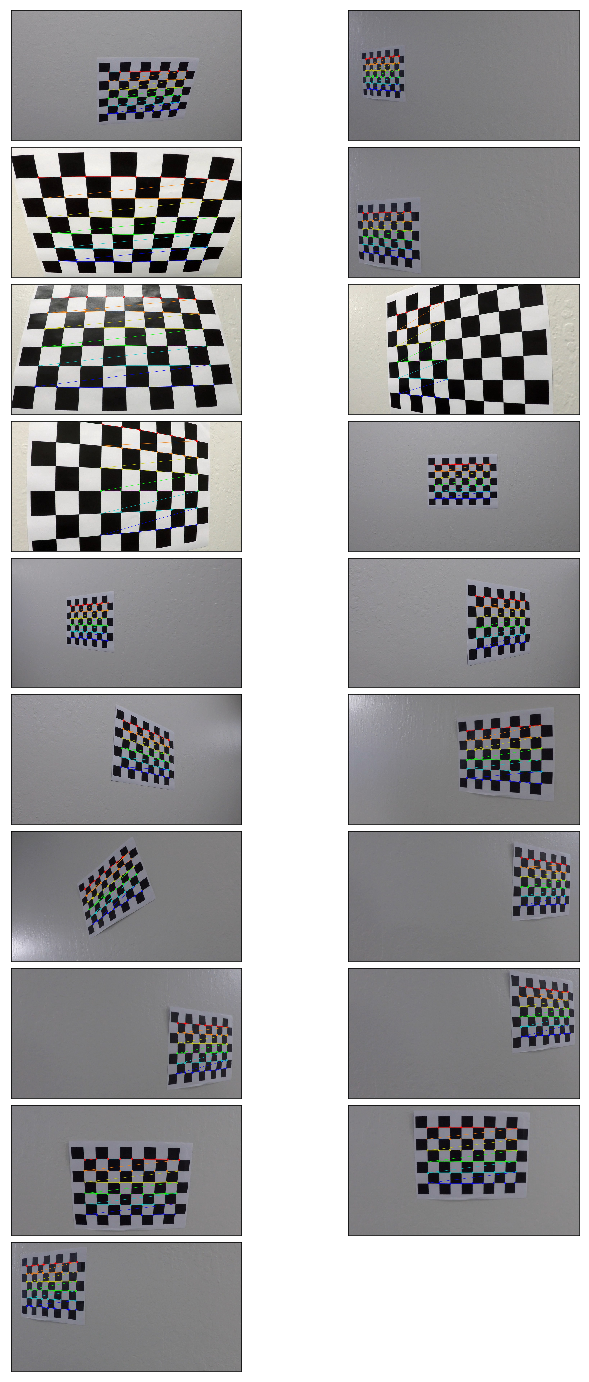

In [2]:
# Calibrate the camera - one-off
calibration = CameraCalibrator()
display_undistorted_image(calibration, TEST_CAL_IMAGE_PATH)
display_undistorted_image(calibration, TEST_FILE_NAME)
display_images_with_corners()

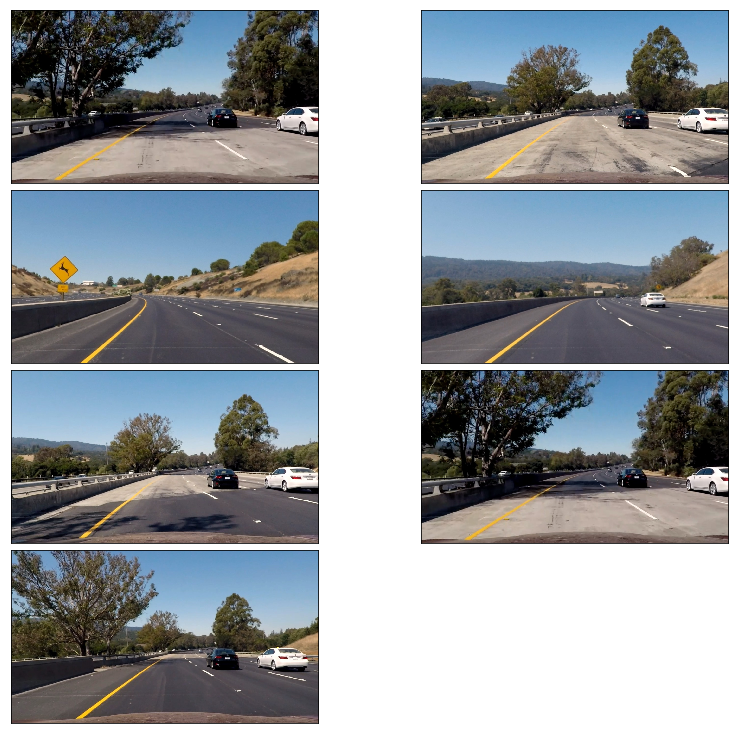

In [3]:
cal_test_images = list(map(calibration.undistort, test_images))
show_images(cal_test_images)

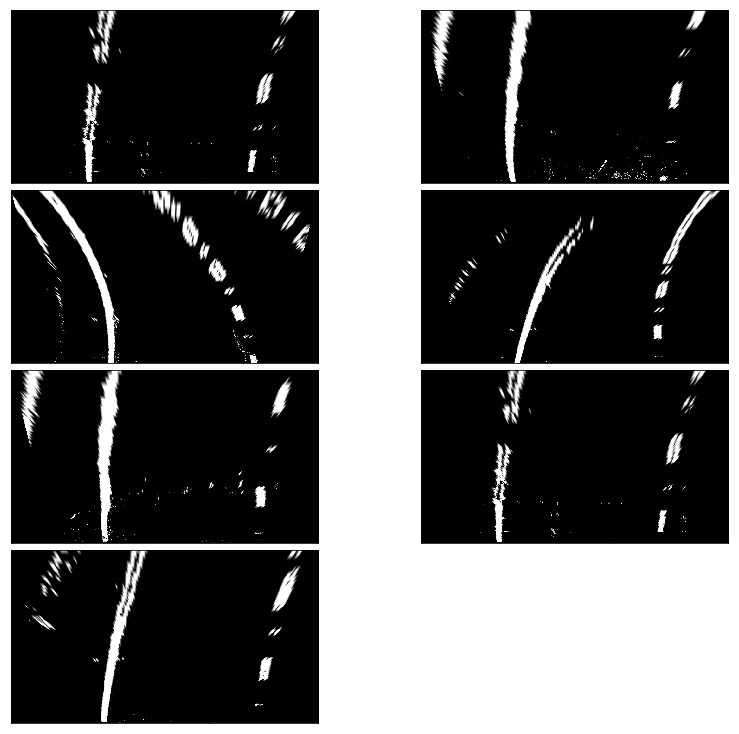

In [4]:
vs = VisionFilters()
binary_test_images = list(map(vs.warp_binary_pipeline, cal_test_images))
show_images(binary_test_images)

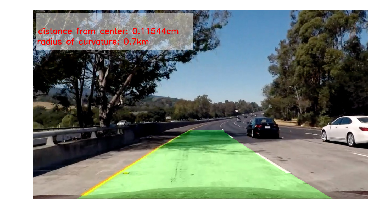

In [5]:
def project_lane_lines(undist, vs, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = vs.unwarp_binary_pipeline(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def process_image(img):
    global left
    global right
    
    calibration = CameraCalibrator()
    vs = VisionFilters()
    undist = calibration.undistort(img)
    warped_binary  = vs.warp_binary_pipeline(undist)

    window_center_l = 340
    if left.detected:
        window_center_l = left.line_pos
    left_binary = FindLines().get_binary_lane_image(warped_binary, left, window_center_l, width=300)

    window_center_r = 940
    if right.detected:
        window_center_r = right.line_pos
    right_binary = FindLines().get_binary_lane_image(warped_binary, right, window_center_r, width=300)

    detected_l = left.update(left_binary)
    detected_r = right.update(right_binary)
    
    lane_width = 3.7
    off_center = round((right.line_pos+left.line_pos)/2-640,2)*3.7/650.0
    
    result = project_lane_lines(undist, vs, left.line_fitx, right.line_fitx, left.ploty)
    # Add information overlay rectangle
    result_overlay = result.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(result_overlay, (10, 10), (610, 150), (255, 255, 255), -1)
    cv2.addWeighted(result_overlay, 0.5, result, 1 - 0.5, 0, result)
    
    # Add curvature and offset information
    
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(19, 90), font, 1,(255,0,0),2,cv2.LINE_AA)
    if left.line_curverad and right.line_curverad:
        curvature = 0.5*(round(right.line_curverad/1000,1) + round(left.line_curverad/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(15, 130), font, 1,(255,0,0),2,cv2.LINE_AA) 
    return result

left = Line(7)
right = Line(7)

img = plt.imread('test_images/curved.jpg')
result = process_image(img)
result = process_image(img)

plt.figure()
plt.imshow(result)
plt.axis('off')
plt.show()

In [6]:
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(OUTPUT_PATH+'processed_project_video.mp4', audio=False)

[MoviePy] >>>> Building video output_images/processed_project_video.mp4
[MoviePy] Writing video output_images/processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [14:00<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/processed_project_video.mp4 

Wall time: 14min 2s
